In [147]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
from functools import partial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.ipython import html
html.html_rdataframe = partial(html.html_rdataframe, table_class = "docutils")
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [148]:
import numpy as np
import matplotlib.pyplot as plt
import sys



def train_ELM(xin : np.ndarray, yin : np.ndarray, p : int, control : bool, lam : float) -> list:
    n = xin.shape[1]
    
    if control == True:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range((n + 1) * p)]).reshape(n + 1, -1)
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin,ones), axis = 1)
    else:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range(n * p)]).reshape(n , -1)

    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)

    diagonal_matrix = lam * np.eye(H.shape[1])
    # w = (HT H + λIp)^(-1)HT y
    w1 = np.linalg.inv(np.dot(np.transpose(H), H) + diagonal_matrix)
    w1 = np.linalg.inv(np.dot(np.transpose(H), H) + diagonal_matrix)
    w = np.dot(w1, np.dot(np.transpose(H), yin))

    return_list = []
    return_list.append(w)   
    return_list.append(H)
    return_list.append(Z)
    return  return_list



def test_ELM(xin: np.ndarray, Z: np.ndarray, W: np.ndarray, control: bool):
    
    if control == True:
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin, ones), axis = 1)
    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)
    Y_hat = np.sign(np.dot(H, W))
    return Y_hat

In [149]:
%%R
library(mlbench)
datasetspirals <- mlbench.spirals(100, sd = 0.05)
XR_datasetspirals <- datasetspirals$x
LABELSR_datasetspirals <- datasetspirals$classes

In [150]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
x_df_espirals = np.array(ro.r['XR_datasetspirals'])
labels_df_espirals = np.array(ro.r['LABELSR_datasetspirals'])
labels_df_espirals[labels_df_espirals == 1] = -1
labels_df_espirals[labels_df_espirals == 2] = 1

In [151]:
from sklearn.model_selection import train_test_split
X_trainspirals, X_testspirals, y_trainspirals, y_testspirals = train_test_split(x_df_espirals, labels_df_espirals, random_state = 0, train_size = 0.7)

[]

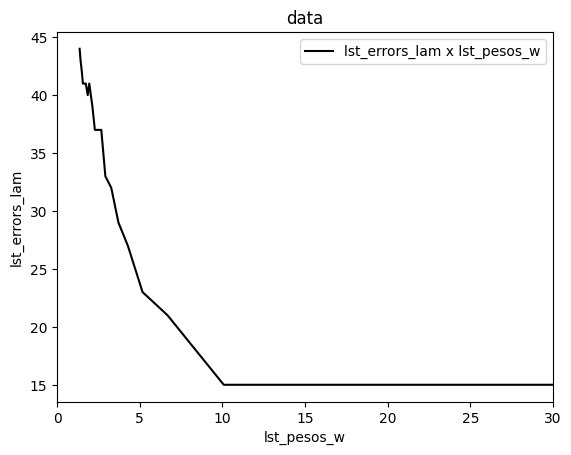

In [152]:
pspirals = 5000
lst_errors_lam = list()
lst_pesos_w = list()
lam = 0
stop = 2
lst_lambda = list()
while lam <= stop:
    train_ELMspirals = train_ELM(X_trainspirals, y_trainspirals, pspirals, control = True, lam = lam)
    wspirals = np.array(train_ELMspirals[0])
    Hspirals = np.array(train_ELMspirals[1])
    Zspirals = np.array(train_ELMspirals[2])
    y_hatrainspirals = test_ELM(X_trainspirals, Zspirals, wspirals, True)
    y_hatestspirals = test_ELM(X_testspirals, Zspirals, wspirals, True)

    # Pegando os erros de treino e os erros de teste.
    sum_result = 0
    sum_errors = np.sum(y_trainspirals != y_hatrainspirals)
    sum_result = sum_result + sum_errors
    sum_errors = np.sum(y_testspirals != y_hatestspirals)
    sum_result = sum_result + sum_errors
    lst_errors_lam.append(sum_result)
    
    lst_lambda.append(lam)
    lst_pesos_w.append(np.linalg.norm(wspirals)) # Norma do vetor w.
    lam = lam + 0.1

# Transformando as listas em arrays numpy.
lst_errors_lam = np.array(lst_errors_lam)
lst_lambda = np.array(lst_lambda)
lst_pesos_w = np.array(lst_pesos_w)
plt.plot(lst_pesos_w, lst_errors_lam, color = 'black', label = 'lst_errors_lam x lst_pesos_w')
plt.title('data')
plt.xlabel('lst_pesos_w')
plt.xlim(0, 30)
plt.ylabel('lst_errors_lam')
plt.legend()
plt.plot()


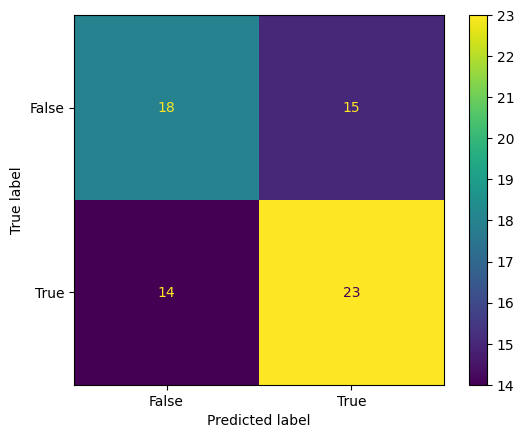

There are a total of 29 errors in the train.


In [153]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_trainspirals, y_hatrainspirals)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
sum_train = np.sum(y_trainspirals != y_hatrainspirals)
print(f"There are a total of {sum_train} errors in the train.")

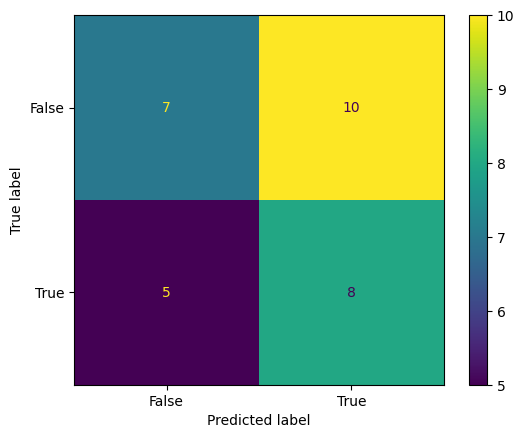

There are a total of 15 errors in the test.


In [154]:
confusion_matrix = metrics.confusion_matrix(y_testspirals, y_hatestspirals)
cm_display_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display_.plot()
plt.show()
sum_test = sum(y_testspirals != y_hatestspirals)
print(f"There are a total of {sum_test} errors in the test.")

In [155]:
labels_df_reshaped = labels_df_espirals.reshape(-1, 1)
mat_plot = np.concatenate((x_df_espirals, labels_df_reshaped), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]

In [156]:
np.unique(mat_plot[:, 2], return_counts = True)

(array([-1.,  1.]), array([50, 50]))

[]

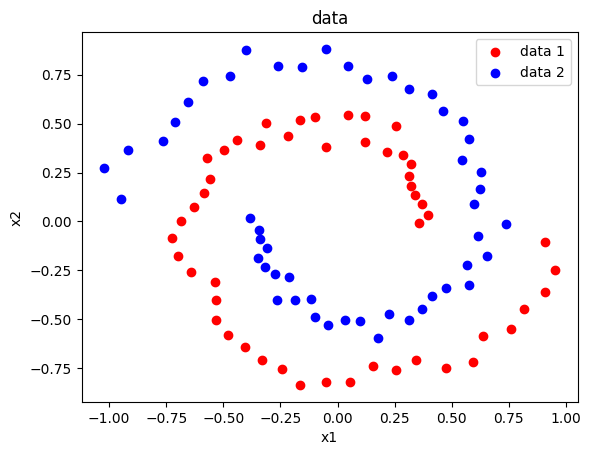

In [157]:
x1_points = mat_plot[: 50, 0 : 2]
x2_points = mat_plot[50 :, 0 : 2]
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data 1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data 2')
plt.title('data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.plot()

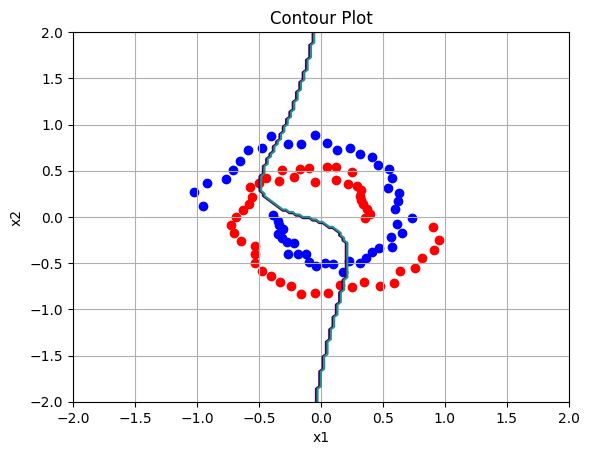

In [158]:
seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, Zspirals))
        h1 = np.column_stack((h1, np.ones_like(h1[:, 0])))
        MZ[i, j] = np.sign(np.dot(h1, wspirals))[0]


plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()